# Exploring And Segmenting The Transactional dataset

  Author: Sourav Dey

In [30]:
#importing the necessary modules

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import re

In [2]:
# Reading the dataset

data=pd.read_csv(r"/Users/souravdey/Desktop/transaction_data.csv")

In [3]:
data.head()

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
0,278166,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
4,-1,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom


In [4]:
data.shape

(1083818, 8)

In [5]:
data.describe()

,UserId,TransactionId,ItemCode,NumberOfItemsPurchased,CostPerItem
count,1.083818e+06,1.083818e+06,1.083818e+06,1.083818e+06,1.083818e+06
mean,2.410162e+05,6.159417e+06,6.582687e+05,2.865675e+01,9.498798e+00
std,1.423364e+05,1.476341e+05,4.526314e+05,6.542432e+02,2.308139e+03
min,-1.000000e+00,5.900015e+06,-1.000000e+00,-2.429850e+05,-1.526564e+04
25%,2.593920e+05,6.026856e+06,4.609080e+05,3.000000e+00,1.730000e+00
50%,3.020220e+05,6.166611e+06,4.752930e+05,9.000000e+00,2.880000e+00
75%,3.413550e+05,6.289569e+06,4.889430e+05,3.000000e+01,5.700000e+00
max,3.840270e+05,6.397457e+06,1.894494e+06,2.429850e+05,1.696285e+06


In [6]:
# Checking for null values

data.isnull().sum()

UserId                       0
TransactionId                0
TransactionTime              0
ItemCode                     0
ItemDescription           2908
NumberOfItemsPurchased       0
CostPerItem                  0
Country                      0
dtype: int64

## Data Cleaning

In [7]:
# Removing Null values

data = data.dropna(axis=0)

In [8]:
# Removing Duplicate rows

print("Number of duplicated rows : {}".format(data.duplicated().sum()))
data = data.drop_duplicates()

Number of duplicated rows : 545792


In [9]:
unique_user,unique_user_count=np.unique(data['UserId'],return_counts=True)
unique_user,unique_user_count

(array([    -1, 259266, 259287, ..., 383922, 383943, 384027]),
 array([133549,      2,    182, ...,     13,    721,     70]))

In [10]:
# Removing datas of unknown users

data = data.query('UserId != "-1"')

In [11]:
unique_user,unique_user_count=np.unique(data['UserId'],return_counts=True)

In [12]:
print('There are {} unique users.'.format(unique_user.shape[0]))

There are 4372 unique users.


In [13]:
unique_country,unique_country_count=np.unique(data['Country'],return_counts=True)

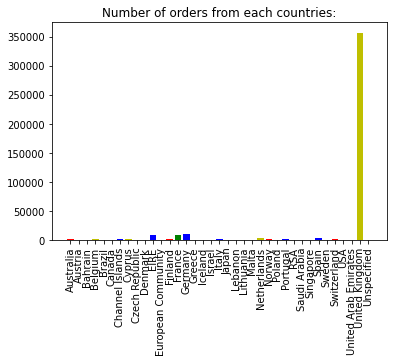

<Figure size 720x576 with 0 Axes>

In [14]:
plt.title('Number of orders from each countries:')
plt.bar(unique_country,unique_country_count,color=['r','g','b','y'])
plt.xticks(unique_country,unique_country,rotation=90)
plt.figure(figsize=(10,8))
plt.show()

In [15]:
# Removing datas of unspecified countries

data = data.query('Country != "Unspecified"')

In [16]:
unique_country,unique_country_count=np.unique(data['Country'],return_counts=True)

In [17]:
print("There are orders from {} countries where {:.2f}% are from United Kingdom.".format(len(unique_country),
((max(unique_country_count)/np.sum(unique_country_count))*100)))

There are orders from 36 countries where 88.88% are from United Kingdom.


In [18]:
data['TransactionTime'] = pd.to_datetime(data['TransactionTime'])

In [19]:
data['TransactionTime'].max()

Timestamp('2028-02-18 13:19:00+0530', tz='pytz.FixedOffset(330)')

In [20]:
# We find there are some noisy values of transaction time

data[data['TransactionTime'] > '2019-02-28 11:59:59+0530']

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
241,366870,5912049,2028-02-18 05:57:00+05:30,473613,PLASTERS IN TIN SKULLS,36,2.28,United Kingdom
602,369411,5914106,2028-02-18 11:39:00+05:30,481278,HERB MARKER PARSLEY,3,0.90,United Kingdom
1070,259287,5913886,2028-02-18 10:57:00+05:30,477246,ALARM CLOCK BAKELIKE GREEN,12,5.18,Iceland
1610,267708,5913864,2028-02-18 10:41:00+05:30,458346,EIGHT PIECE DINOSAUR SET,9,1.73,United Kingdom
1792,315504,5913688,2028-02-18 09:20:00+05:30,453432,RETROSPOT CIGAR BOX MATCHES,12,1.73,United Kingdom
...,...,...,...,...,...,...,...,...
1005863,333018,5913853,2028-02-18 10:31:00+05:30,481803,CHRISTMAS LIGHTS 10 VINTAGE BAUBLES,6,6.84,United Kingdom
1017804,352275,5913974,2028-02-18 11:15:00+05:30,464373,GREY HEART HOT WATER BOTTLE,9,5.18,United Kingdom
1039130,371175,5913699,2028-02-18 09:22:00+05:30,477246,ALARM CLOCK BAKELIKE GREEN,24,5.18,United Kingdom
1052713,297696,5912753,2028-02-18 07:45:00+05:30,448455,TOAST ITS - I LOVE YOU,36,1.73,United Kingdom


In [21]:
# Removing datas where transaction time is beyond february 2019

data = data[data['TransactionTime'] < '2019-02-28 11:59:59+0530']

In [22]:
unique_item,unique_item_count=np.unique(data['ItemCode'],return_counts=True)
unique_item,unique_item_count

(array([     -1,      42,  210042, ..., 1894431, 1894452, 1894494]),
 array([1777,  134,   49, ...,    6,    3,  117]))

In [23]:
# Removing datas of unknown items

data = data.query('ItemCode != "-1"')

In [24]:
data.head()

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
0,278166,6355745,2019-02-02 12:50:00+05:30,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701,6283376,2018-12-26 09:06:00+05:30,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099,6385599,2019-02-15 09:45:00+05:30,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478,6044973,2018-06-22 07:14:00+05:30,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
5,285957,6307136,2019-01-11 09:50:00+05:30,1787247,CUT GLASS T-LIGHT HOLDER OCTAGON,12,3.52,United Kingdom


In [25]:
data = data.reset_index()

## Feature Extraction

In [26]:
# Creating a new features from two other given features

amount_purchased=[]
for i in range(len(data)):
    amount_purchased.append(data['NumberOfItemsPurchased'][i] * data['CostPerItem'][i])

In [27]:
data['amount_purchased'] = amount_purchased

In [28]:
data = data.drop(labels=['NumberOfItemsPurchased','CostPerItem'],axis=1)

## Feature extraction using NLP

 Here we are dealing with the string feature ItemDescription.
 We will categorize the items into different categories using there Description.

In [31]:
# Stemming ,splitting and removing the stopwords

temp = data['ItemDescription'].unique()
ps = PorterStemmer()
temp1 = []
temp3 = []
for i in range(0,len(temp)):
    temp2=re.sub('[^a-zA-Z]',' ',temp[i])
    temp2=temp2.lower()
    temp2=temp2.split()
    temp2=[ps.stem(word) for word in temp2 if not word in stopwords.words('english')]
    temp1.append(temp2)
    temp3.extend(temp2)

In [32]:
print("temp3: {}".format(temp3[:5]))
print("---------------------------------------------------------------")
print("temp1: {}".format(temp1[:5]))

temp3: ['famili', 'album', 'white', 'pictur', 'frame']
---------------------------------------------------------------
temp1: [['famili', 'album', 'white', 'pictur', 'frame'], ['london', 'bu', 'coffe', 'mug'], ['set', 'colour', 'pencil', 'dolli', 'girl'], ['union', 'jack', 'flag', 'luggag', 'tag'], ['cut', 'glass', 'light', 'holder', 'octagon']]


In [33]:
unique_words,unique_words_count=np.unique(temp3,return_counts=True)

In [34]:
dic = {unique_words[i]: unique_words_count[i] for i in range(len(unique_words))}

In [35]:
dic = sorted(dic.items(), key = lambda kv:(kv[1], kv[0]),reverse=True)

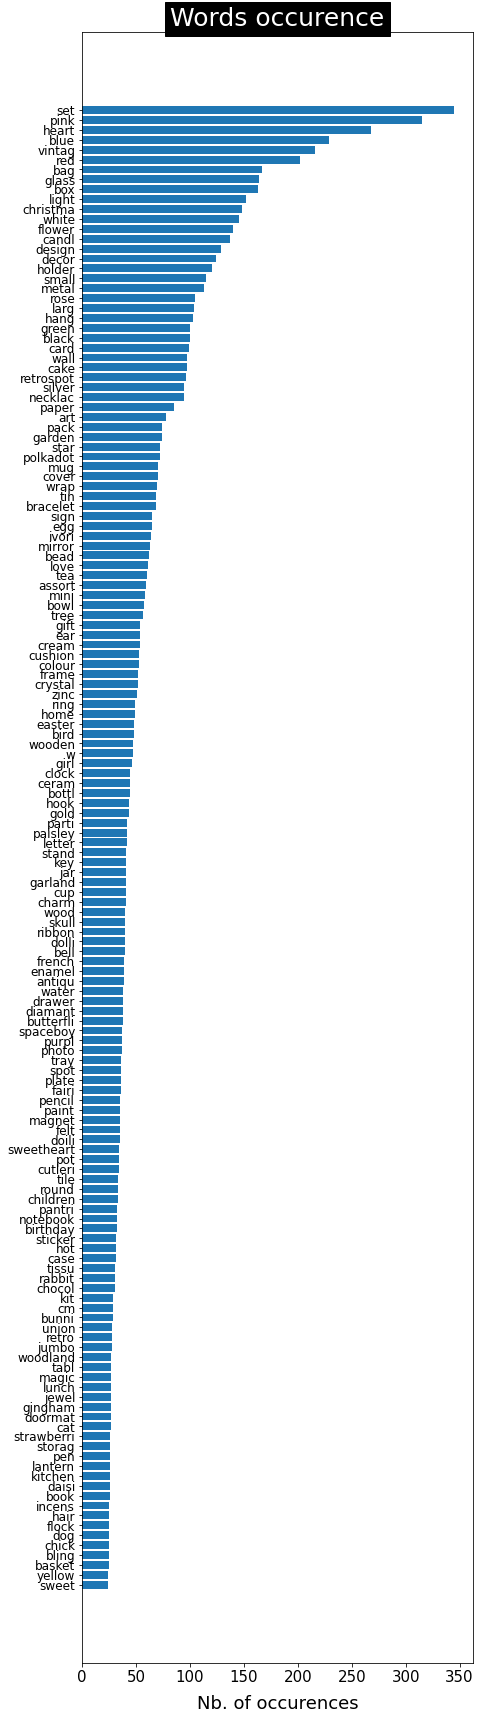

In [36]:
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 30))
y_axis = [i[1] for i in dic[:150]]
x_axis = [k for k,i in enumerate(dic[:150])]
x_label = [i[0] for i in dic[:150]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 12)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

In [37]:
# Some of the words doesn't carrying any information , so we have to remove them.

for i in dic:
    if (i[0] in ['pink','blue', 'green', 'orange','white','black','red']) or (len(i[0]) < 3):
        dic.remove(i)

In [38]:
dic = pd.DataFrame(dic,columns=['words','counts'])

In [39]:
# Remove the words which appears less than 10 times

dic = dic.query('counts > 10') 

In [40]:
columns = list(dic['words'])

In [41]:
# This function acts like CountVectorizer of sklearn.
# It returns the list with boolean values where 0 means a word is not present and 1 means the word is present

def bow(bag,words):
    val = []
    for i in words:
        if i in bag:
            val.append(1)
        else:
            val.append(0)
    return val

In [42]:
val = []
for i in temp1:
    val.append(bow(i,columns))

In [43]:
len(val)

3888

In [44]:
len(temp)

3888

In [45]:
dic = pd.DataFrame(val,columns=columns)

In [46]:
dic['ItemDescription'] = temp

## Bag Of Words

The bag-of-words model is a simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity.

For more information: https://en.wikipedia.org/wiki/Bag-of-words_model

In [47]:
dic.head()

,set,heart,vintag,bag,glass,box,light,christma,flower,candl,...,doll,curtain,chunki,charlott,brown,breakfast,babi,anim,amber,ItemDescription
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,FAMILY ALBUM WHITE PICTURE FRAME
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,LONDON BUS COFFEE MUG
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,SET 12 COLOUR PENCILS DOLLY GIRL
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,UNION JACK FLAG LUGGAGE TAG
4,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,CUT GLASS T-LIGHT HOLDER OCTAGON


In [48]:
x = dic.drop(labels='ItemDescription',axis=1)

In [49]:
# For dimensionality reduction
pca=PCA(random_state=42)

# Fit the PCA model with original data of higher dimensions
pca.fit(x)

# x_pca will contains the transfored data with very low dimensions
x_pca=pca.transform(x)

In [50]:
x_train_pca = x_pca[:int((x_pca.shape[0])*.8)]
x_test_pca = x_pca[int((x_pca.shape[0])*.8):]

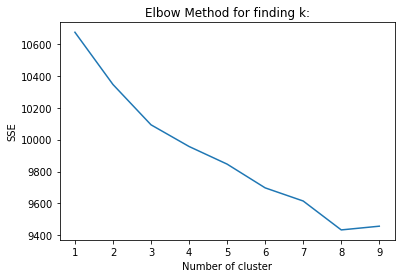

In [51]:
sse = {}
for k in range(1, 10):

    km = KMeans(n_clusters=k, max_iter=1000).fit(x_pca)

    sse[k] = km.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()

plt.plot(list(sse.keys()), list(sse.values()))

plt.title("Elbow Method for finding k:")

plt.xlabel("Number of cluster")

plt.ylabel("SSE")

plt.show()

In [52]:
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(x_train_pca)
    clusters = kmeans.predict(x_test_pca)
    silhouette_avg = silhouette_score(x_test_pca, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.07246766049688846
For n_clusters = 4 The average silhouette_score is : 0.06668227159269177
For n_clusters = 5 The average silhouette_score is : 0.03608199427554308
For n_clusters = 6 The average silhouette_score is : 0.017209500519704657
For n_clusters = 7 The average silhouette_score is : 0.05596786005628183
For n_clusters = 8 The average silhouette_score is : 0.029726995349543057
For n_clusters = 9 The average silhouette_score is : 0.006322854635480286


In [53]:
n_clusters = 3

In [54]:
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(x_train_pca)
clusters = kmeans.predict(x_pca)
silhouette_avg = silhouette_score(x_pca, clusters)
print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.07319036823365041


In [55]:
pd.Series(clusters).value_counts()

0    3291
1     333
2     264
dtype: int64

In [56]:
corresp = dict()
for key, val in zip (temp, clusters):
    corresp[key] = val 

In [57]:
product_category = []
for i in data['ItemDescription']:
    product_category.append(corresp[i])

In [58]:
data['product_category'] = product_category

In [59]:
data['cat0'],data['cat1'],data['cat2'] = 0,0,0
for i in range(len(data)):
    var = data['product_category'][i]
    data['cat{}'.format(var)][i] = 1

/Users/souravdey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [60]:
data = data.drop(['product_category','ItemDescription'],axis=1)

In [61]:
data

,index,UserId,TransactionId,TransactionTime,ItemCode,Country,amount_purchased,cat0,cat1,cat2
0,0,278166,6355745,2019-02-02 12:50:00+05:30,465549,United Kingdom,70.38,1,0,0
1,1,337701,6283376,2018-12-26 09:06:00+05:30,482370,United Kingdom,10.56,1,0,0
2,2,267099,6385599,2019-02-15 09:45:00+05:30,490728,France,64.80,0,1,0
3,3,380478,6044973,2018-06-22 07:14:00+05:30,459186,United Kingdom,5.19,1,0,0
4,5,285957,6307136,2019-01-11 09:50:00+05:30,1787247,United Kingdom,42.24,1,0,0
...,...,...,...,...,...,...,...,...,...,...
398429,1080031,324303,6204462,2018-11-03 08:52:00+05:30,487452,United Kingdom,186.84,0,0,1
398430,1080203,374661,5911455,2018-02-17 10:51:00+05:30,448581,United Kingdom,52.80,1,0,0
398431,1081224,342636,6268328,2018-12-18 09:48:00+05:30,481761,United Kingdom,281.52,1,0,0
398432,1081271,374577,6277348,2018-12-23 10:34:00+05:30,478506,United Kingdom,73.98,1,0,0


## Extracting Features

The dataset previously contains about 11 lakhs data but most of them are unwanted , noisy ,duplicates so after data cleaning we get a dataset of about 4200 unique users.

In [62]:
final_data = data.groupby('UserId').agg({'amount_purchased': ['min','max','mean','sum','count'] ,
                        'cat0' : 'sum',
                        'cat1' : 'sum',
                        'cat2' : 'sum',
                        'TransactionTime': [lambda y: (data['TransactionTime'].max().date() - y.max().date()).days,
                                            lambda y: (data['TransactionTime'].max().date() - y.min().date()).days]})

In [63]:
final_data.columns = ['min_purchased','max_purchased','mean_purchased','total_purchased','frequency','cat0','cat1','cat2','LastPurchase','FirstPurchase']

In [64]:
final_data

,min_purchased,max_purchased,mean_purchased,total_purchased,frequency,cat0,cat1,cat2,LastPurchase,FirstPurchase
UserId,,,,,,,,,,
259266,-320608.80,320608.80,0.000000,0.00,2,2,0,0,325,325
259287,20.88,1036.80,98.862119,14928.18,151,123,19,9,2,317
259308,54.72,622.80,221.893333,5991.12,27,22,3,2,75,358
259329,27.60,264.24,83.943333,6043.92,72,47,15,10,18,18
259350,35.40,104.40,76.350000,1221.60,16,16,0,0,310,310
...,...,...,...,...,...,...,...,...,...,...
383880,61.56,98.19,74.865000,748.65,10,9,1,0,277,277
383901,20.88,70.20,47.828571,334.80,7,5,2,0,180,180
383922,-6.15,105.60,56.388462,733.05,13,12,1,0,7,126


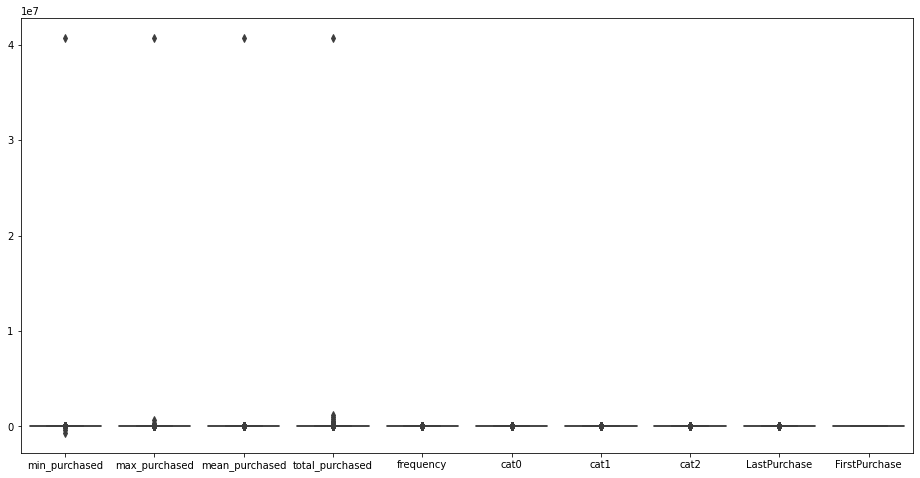

In [65]:
# Boxplots for checking outliers in the data

fig = plt.subplots(figsize=(16,8))
sns.boxplot(data=final_data)

In [66]:
# Removing the outliers from the dataset

final_data = final_data.drop(final_data[(np.abs(stats.zscore(final_data))>3)].index)

In [67]:
final_data

,min_purchased,max_purchased,mean_purchased,total_purchased,frequency,cat0,cat1,cat2,LastPurchase,FirstPurchase
UserId,,,,,,,,,,
259266,-320608.80,320608.80,0.000000,0.00,2,2,0,0,325,325
259287,20.88,1036.80,98.862119,14928.18,151,123,19,9,2,317
259308,54.72,622.80,221.893333,5991.12,27,22,3,2,75,358
259329,27.60,264.24,83.943333,6043.92,72,47,15,10,18,18
259350,35.40,104.40,76.350000,1221.60,16,16,0,0,310,310
...,...,...,...,...,...,...,...,...,...,...
383838,42.48,123.12,80.133333,721.20,9,7,1,1,73,73
383880,61.56,98.19,74.865000,748.65,10,9,1,0,277,277
383901,20.88,70.20,47.828571,334.80,7,5,2,0,180,180


In [68]:
final_data = final_data.drop(['min_purchased','max_purchased','mean_purchased'], axis=1)

In [69]:
final_data

,total_purchased,frequency,cat0,cat1,cat2,LastPurchase,FirstPurchase
UserId,,,,,,,
259266,0.00,2,2,0,0,325,325
259287,14928.18,151,123,19,9,2,317
259308,5991.12,27,22,3,2,75,358
259329,6043.92,72,47,15,10,18,18
259350,1221.60,16,16,0,0,310,310
...,...,...,...,...,...,...,...
383838,721.20,9,7,1,1,73,73
383880,748.65,10,9,1,0,277,277
383901,334.80,7,5,2,0,180,180


In [70]:
sc = StandardScaler()

In [71]:
sc_data = sc.fit_transform(final_data)

In [72]:
sc_data

array([[-0.34504713, -0.76713978, -0.74142092, ..., -0.64188012,
         2.30837418,  0.86765918],
       [ 0.45644373,  0.77756489,  0.77281315, ...,  0.31900025,
        -0.89727107,  0.79981803],
       [-0.02338515, -0.50796115, -0.4911343 , ..., -0.42835115,
        -0.1727754 ,  1.14750393],
       ...,
       [-0.32707179, -0.71530406, -0.70387793, ..., -0.64188012,
         0.86930742, -0.3619617 ],
       [-0.30568983, -0.65310118, -0.61627761, ..., -0.64188012,
        -0.84764808, -0.81988948],
       [ 0.06455872, -0.06217389, -0.07816137, ..., -0.53511564,
        -0.50028714, -0.18387868]])

## After Some Research I Found That There Are Two Types Of Segmentation 

#### 1. Behavioural Segmentation
#### 2. Demographic Segmentation

# Behavioural Segmentation

In [73]:
final_data.shape

(4293, 7)

In [74]:
# For dimensionality reduction
pca1=PCA(random_state=42)

# Fit the PCA model with original data of higher dimensions
pca1.fit(sc_data)

# x_pca will contains the transfored data with very low dimensions
final_data_pca=pca1.transform(sc_data)

In [75]:
final_data_train_pca = final_data_pca[:int((final_data_pca.shape[0])*.8)]
final_data_test_pca = final_data_pca[int((final_data_pca.shape[0])*.8):]

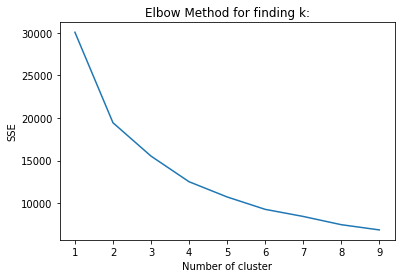

In [76]:
sse = {}
for k in range(1, 10):

    km1 = KMeans(n_clusters=k, max_iter=1000).fit(final_data_pca)

    sse[k] = km1.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()

plt.plot(list(sse.keys()), list(sse.values()))

plt.title("Elbow Method for finding k:")

plt.xlabel("Number of cluster")

plt.ylabel("SSE")

plt.show()

In [77]:
for i in range(2,15):
    kmeans1 = KMeans(init='k-means++', n_clusters = i, n_init=30)
    kmeans1.fit(final_data_pca)
    clusters1 = kmeans1.predict(final_data_pca)
    silhouette_avg = silhouette_score(final_data_pca, clusters1)
    print("For n_clusters =", i, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.5299692220486226
For n_clusters = 3 The average silhouette_score is : 0.3194363655469615
For n_clusters = 4 The average silhouette_score is : 0.3633674653018094
For n_clusters = 5 The average silhouette_score is : 0.36963268936855737
For n_clusters = 6 The average silhouette_score is : 0.36173386446046574
For n_clusters = 7 The average silhouette_score is : 0.3625218689608025
For n_clusters = 8 The average silhouette_score is : 0.37105526465035
For n_clusters = 9 The average silhouette_score is : 0.3507252078785851
For n_clusters = 10 The average silhouette_score is : 0.3098380571324678
For n_clusters = 11 The average silhouette_score is : 0.31580341467960904
For n_clusters = 12 The average silhouette_score is : 0.30878540621934997
For n_clusters = 13 The average silhouette_score is : 0.30446778351510545
For n_clusters = 14 The average silhouette_score is : 0.30501944347207705


In [78]:
n_clusters1 = 4

In [79]:
kmeans1 = KMeans(init='k-means++', n_clusters = n_clusters1, n_init=30)
kmeans1.fit(final_data_train_pca)
clusters1 = kmeans1.predict(final_data_test_pca)
silhouette_avg = silhouette_score(final_data_test_pca, clusters1)
print("For n_clusters =", n_clusters1, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 4 The average silhouette_score is : 0.35470594529262056


In [80]:
pd.Series(clusters1).value_counts()

1    294
0    269
2    222
3     74
dtype: int64

In [81]:
final_data['clusters'] = kmeans1.predict(final_data_pca)

In [82]:
customer_segment_1 = final_data[final_data['clusters'] == 0]
customer_segment_1

,total_purchased,frequency,cat0,cat1,cat2,LastPurchase,FirstPurchase,clusters
UserId,,,,,,,,
259287,14928.18,151,123,19,9,2,317,0
259308,5991.12,27,22,3,2,75,358,0
259392,5247.12,84,59,16,9,36,296,0
259476,10318.11,58,29,15,14,22,325,0
259560,9550.08,126,99,26,1,52,200,0
...,...,...,...,...,...,...,...,...
383460,10702.77,139,107,12,20,172,358,0
383523,5037.12,62,54,4,4,23,252,0
383712,12717.30,170,113,52,5,2,246,0


In [83]:
customer_segment_2 = final_data[final_data['clusters'] == 1]
customer_segment_2

,total_purchased,frequency,cat0,cat1,cat2,LastPurchase,FirstPurchase,clusters
UserId,,,,,,,,
259329,6.043920e+03,72,47,15,10,18,18,1
259497,2.573796e+04,131,118,6,7,33,33,1
259518,3.846840e+03,17,17,0,0,1,150,1
259644,5.016000e+03,81,61,18,2,7,112,1
259707,6.262800e+02,10,9,1,0,4,4,1
...,...,...,...,...,...,...,...,...
383733,8.448000e+02,3,3,0,0,2,257,1
383754,3.552714e-14,22,6,16,0,17,30,1
383796,1.341600e+03,16,11,2,3,21,43,1


In [84]:
customer_segment_3 = final_data[final_data['clusters'] == 2]
customer_segment_3

,total_purchased,frequency,cat0,cat1,cat2,LastPurchase,FirstPurchase,clusters
UserId,,,,,,,,
259266,0.00,2,2,0,0,325,325,2
259350,1221.60,16,16,0,0,310,310,2
259413,369.00,4,4,0,0,204,204,2
259434,4479.54,58,49,8,1,232,232,2
259455,1905.78,13,13,0,0,214,214,2
...,...,...,...,...,...,...,...,...
383250,1422.21,22,15,6,1,301,310,2
383376,-208.32,4,4,0,0,354,354,2
383649,576.18,8,6,2,0,358,366,2


In [85]:
customer_segment_4 = final_data[final_data['clusters'] == 3]
customer_segment_4

,total_purchased,frequency,cat0,cat1,cat2,LastPurchase,FirstPurchase,clusters
UserId,,,,,,,,
259539,25589.49,250,225,22,3,7,331,3
259602,19349.64,264,219,38,7,3,295,3
259938,16632.72,219,174,29,16,129,129,3
260988,26402.64,292,238,46,8,25,283,3
261051,25906.32,237,188,38,11,35,373,3
...,...,...,...,...,...,...,...,...
380436,5794.38,368,281,41,46,67,364,3
380562,7433.49,354,266,38,50,8,150,3
382683,26212.59,298,223,63,12,1,358,3


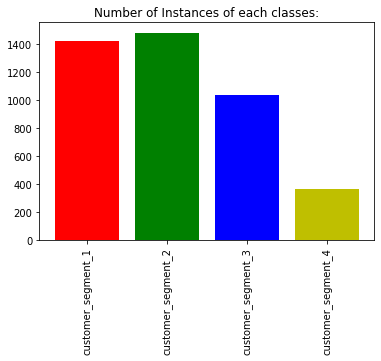

In [86]:
plt.title('Number of Instances of each classes:')
plt.bar(['customer_segment_1','customer_segment_2','customer_segment_3','customer_segment_4'],[len(customer_segment_1),len(customer_segment_2),len(customer_segment_3),len(customer_segment_4)],color=['r','g','b','y'])
plt.xticks(['customer_segment_1','customer_segment_2','customer_segment_3','customer_segment_4'],['customer_segment_1','customer_segment_2','customer_segment_3','customer_segment_4'],rotation=90)
plt.show()

# Customer Segments

In [87]:
customer_segment_1.describe()

,total_purchased,frequency,cat0,cat1,cat2,LastPurchase,FirstPurchase,clusters
count,1419.000000,1419.000000,1419.000000,1419.000000,1419.000000,1419.000000,1419.000000,1419.0
mean,8212.022452,96.026075,77.427061,10.926709,7.672304,42.198027,294.018323,0.0
std,11555.429203,52.587170,44.765690,9.028336,7.610244,42.176115,71.456801,0.0
min,-72.360000,2.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.0
25%,3234.600000,53.000000,41.000000,4.000000,2.000000,11.000000,254.500000,0.0
50%,5747.430000,90.000000,73.000000,9.000000,6.000000,29.000000,309.000000,0.0
75%,9723.120000,132.000000,106.000000,16.000000,11.000000,60.000000,359.000000,0.0
max,220796.640000,271.000000,258.000000,53.000000,54.000000,306.000000,373.000000,0.0


In [88]:
print('Customer Segment 1 :')
print("Customers of this segment has mean purchase record of {} with a minimum purchase of {} and maximum purchase amount of {}.".format((customer_segment_1['total_purchased'].mean()),(customer_segment_1['total_purchased'].min()),(customer_segment_1['total_purchased'].max())))
print("Note: If the minimum amount is negative that means the customer has canceled that order.")

Customer Segment 1 :
Customers of this segment has mean purchase record of 8212.022452431287 with a minimum purchase of -72.36 and maximum purchase amount of 220796.64.
Note: If the minimum amount is negative that means the customer has canceled that order.


In [89]:
customer_segment_2.describe()

,total_purchased,frequency,cat0,cat1,cat2,LastPurchase,FirstPurchase,clusters
count,1479.000000,1479.000000,1479.000000,1479.000000,1479.000000,1479.000000,1479.000000,1479.0
mean,2304.053043,31.565923,24.956051,3.956051,2.653820,49.774848,88.863421,1.0
std,2724.237963,25.700251,20.765234,4.614074,3.741545,40.267778,62.528037,0.0
min,-1925.760000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,866.625000,12.000000,10.000000,0.000000,0.000000,17.500000,39.500000,1.0
50%,1556.040000,25.000000,20.000000,2.000000,1.000000,40.000000,74.000000,1.0
75%,2824.035000,44.000000,35.000000,6.000000,4.000000,73.000000,130.000000,1.0
max,51371.100000,156.000000,130.000000,29.000000,30.000000,163.000000,290.000000,1.0


In [90]:
print('Customer Segment 2 :')
print("Customers of this segment has mean purchase record of {} with a minimum purchase of {} and maximum purchase amount of {}.".format((customer_segment_2['total_purchased'].mean()),(customer_segment_2['total_purchased'].min()),(customer_segment_2['total_purchased'].max())))
print("Note: If the minimum amount is negative that means the customer has canceled that order.")

Customer Segment 2 :
Customers of this segment has mean purchase record of 2304.0530425963493 with a minimum purchase of -1925.76 and maximum purchase amount of 51371.1.
Note: If the minimum amount is negative that means the customer has canceled that order.


In [91]:
customer_segment_3.describe()


,total_purchased,frequency,cat0,cat1,cat2,LastPurchase,FirstPurchase,clusters
count,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.0
mean,1852.507994,22.678295,18.181202,2.533915,1.963178,248.283915,284.331395,2.0
std,3695.040435,21.072578,17.020873,3.485151,3.133716,70.189613,60.332707,0.0
min,-4938.480000,1.000000,0.000000,0.000000,0.000000,72.000000,163.000000,2.0
25%,652.207500,8.000000,6.000000,0.000000,0.000000,192.000000,239.000000,2.0
50%,1229.370000,17.000000,13.000000,1.000000,1.000000,246.000000,284.000000,2.0
75%,2022.592500,29.000000,24.000000,4.000000,3.000000,303.000000,334.000000,2.0
max,89292.300000,159.000000,117.000000,42.000000,26.000000,373.000000,373.000000,2.0


In [92]:
print('Customer Segment 3 :')

print("Customers of this segment has mean purchase record of {} with a minimum purchase of {} and maximum purchase amount of {}.".format((customer_segment_3['total_purchased'].mean()),(customer_segment_3['total_purchased'].min()),(customer_segment_3['total_purchased'].max())))
print("Note: If the minimum amount is negative that means the customer has canceled that order.")

Customer Segment 3 :
Customers of this segment has mean purchase record of 1852.507994186048 with a minimum purchase of -4938.4800000000005 and maximum purchase amount of 89292.3.
Note: If the minimum amount is negative that means the customer has canceled that order.


In [93]:
customer_segment_4.describe()

,total_purchased,frequency,cat0,cat1,cat2,LastPurchase,FirstPurchase,clusters
count,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.0
mean,29249.027686,330.316804,268.280992,37.319559,24.716253,19.245179,313.798898,3.0
std,53459.617556,113.782561,103.020667,18.709832,16.552259,28.936069,79.417533,0.0
min,2400.240000,147.000000,86.000000,4.000000,0.000000,0.000000,10.000000,3.0
25%,10140.375000,250.000000,194.000000,23.500000,12.000000,3.000000,287.500000,3.0
50%,16934.160000,299.000000,245.000000,35.000000,22.000000,10.000000,354.000000,3.0
75%,26851.170000,390.000000,319.000000,49.000000,35.000000,23.500000,368.000000,3.0
max,777549.600000,741.000000,624.000000,88.000000,70.000000,302.000000,373.000000,3.0


In [94]:
print('Customer Segment 4 :')
print("Customers of this segment has mean purchase record of {} with a minimum purchase of {} and maximum purchase amount of {}.".format((customer_segment_4['total_purchased'].mean()),(customer_segment_4['total_purchased'].min()),(customer_segment_4['total_purchased'].max())))
print("Note: If the minimum amount is negative that means the customer has canceled that order.")

Customer Segment 4 :
Customers of this segment has mean purchase record of 29249.02768595041 with a minimum purchase of 2400.2400000000002 and maximum purchase amount of 777549.6000000008.
Note: If the minimum amount is negative that means the customer has canceled that order.


In [103]:
Users_of_customer_segment_1 = customer_segment_1.index.to_list()
Users_of_customer_segment_2 = customer_segment_2.index.to_list()
Users_of_customer_segment_3 = customer_segment_3.index.to_list()
Users_of_customer_segment_4 = customer_segment_4.index.to_list()